In [1]:
%%time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# import requests
# import json

Wall time: 1.32 s


In [2]:
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [4]:
# df = pd.read_csv('daily_WFC.csv', index_col='timestamp', parse_dates=True)
df = pd.read_csv('intraday_5min_WFC.csv', index_col='timestamp', parse_dates=True)

df.sort_index(ascending=True, inplace=True)
df = df.asfreq(freq='5min', method='bfill')

In [5]:
df.index

DatetimeIndex(['2019-10-21 09:35:00', '2019-10-21 09:40:00',
               '2019-10-21 09:45:00', '2019-10-21 09:50:00',
               '2019-10-21 09:55:00', '2019-10-21 10:00:00',
               '2019-10-21 10:05:00', '2019-10-21 10:10:00',
               '2019-10-21 10:15:00', '2019-10-21 10:20:00',
               ...
               '2019-11-08 15:15:00', '2019-11-08 15:20:00',
               '2019-11-08 15:25:00', '2019-11-08 15:30:00',
               '2019-11-08 15:35:00', '2019-11-08 15:40:00',
               '2019-11-08 15:45:00', '2019-11-08 15:50:00',
               '2019-11-08 15:55:00', '2019-11-08 16:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=5262, freq='5T')

In [ ]:
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df = df.set_index('timestamp')
# df.sort_index(ascending=True, inplace=True)

In [6]:
df.dropna(inplace=True)
df.shape

(5262, 5)

In [7]:
df =df[df.index > '31-10-2019']

# df = df[df.index > '30-06-2019']
df.shape

(2496, 5)

In [8]:
adf_test(df['open'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -0.896252
p-value                    0.789204
# lags used               24.000000
# observations          2471.000000
critical value (1%)       -3.432999
critical value (5%)       -2.862710
critical value (10%)      -2.567393
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [9]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df['open'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.049328e+01
p-value                 1.132406e-18
# lags used             2.300000e+01
# observations          2.471000e+03
critical value (1%)    -3.432999e+00
critical value (5%)    -2.862710e+00
critical value (10%)   -2.567393e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [10]:
stepwise_fit = auto_arima(df['open'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=-10647.837, BIC=-10636.193, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-10647.089, BIC=-10629.622, Fit time=0.077 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-10647.075, BIC=-10629.609, Fit time=0.030 seconds
Fit ARIMA: order=(1, 1, 1); AIC=-10657.567, BIC=-10634.279, Fit time=0.572 seconds
Fit ARIMA: order=(2, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.589 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2495
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5332.783
Method:                       css-mle   S.D. of innovations              0.029
Date:                Mon, 11 Nov 2019   AIC                         -10657.567
Time:                        12:47:04   BIC                         -10634.279
Sample:                             1   HQIC                        -10649.111
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.616      0.106      -0.000       0.002
ar.L1.D.y     -0.9515      0.028    -33.722      0.000      -1.007      -0.896
ma.L1.D.y      0.9286      0.034     27.401      0.000       0.862       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0510           +0.0000j            1.0510            0.5000
MA.1           -1.0768           +0.0000j            1.0768            0.5000
-----------------------------------------------------------------------------
"""

In [11]:
auto_arima(df['open'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2495
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5332.783
Method:                       css-mle   S.D. of innovations              0.029
Date:                Mon, 11 Nov 2019   AIC                         -10657.567
Time:                        12:47:11   BIC                         -10634.279
Sample:                             1   HQIC                        -10649.111
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.616      0.106      -0.000       0.002
ar.L1.D.y     -0.9515      0.028    -33.722      0.000      -1.007      -0.896
ma.L1.D.y      0.9286      0.034     27.401      0.000       0.862       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0510           +0.0000j            1.0510            0.5000
MA.1           -1.0768           +0.0000j            1.0768            0.5000
-----------------------------------------------------------------------------
"""

In [12]:
len(df)

2496

In [13]:

train = df.iloc[:1500]
test = df.iloc[1500:]

# train = df[df.index <= '31-10-2019']
# test = df[df.index > '31-10-2019']

print(len(train), len(test))

1500 996


In [14]:
model = ARIMA(train['open'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.open   No. Observations:                 1499
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3298.943
Method:                       css-mle   S.D. of innovations              0.027
Date:                Mon, 11 Nov 2019   AIC                          -6589.886
Time:                        12:49:16   BIC                          -6568.636
Sample:                    10-31-2019   HQIC                         -6581.969
                         - 11-05-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0006      0.001      0.923      0.356      -0.001       0.002
ar.L1.D.open     0.0098      0.631      0.016      0.988      -1.227       1.247
ma.L1.D.open     0.0009      0.631      0.001      0.999      -1.235       1.237
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          101.8522           +0.0000j          101.8522            0.0000
MA.1        -1126.7286           +0.0000j         1126.7286            0.5000
-----------------------------------------------------------------------------
"""

In [15]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA Predictions')

In [ ]:
# predictions = predictions.reset_index(drop=True)
# predictions.index = test.index

In [16]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['open'][i]}")

predicted=52.74063891, expected=52.74
predicted=52.74128466, expected=52.74
predicted=52.74193047, expected=52.74
predicted=52.74257629, expected=52.74
predicted=52.74322211, expected=52.74
predicted=52.74386792, expected=52.74
predicted=52.74451374, expected=52.74
predicted=52.74515955, expected=52.74
predicted=52.74580537, expected=52.74
predicted=52.74645119, expected=52.74
predicted=52.747097  , expected=52.74
predicted=52.74774282, expected=52.74
predicted=52.74838864, expected=52.74
predicted=52.74903445, expected=52.74
predicted=52.74968027, expected=52.74
predicted=52.75032609, expected=52.74
predicted=52.7509719 , expected=52.74
predicted=52.75161772, expected=52.74
predicted=52.75226354, expected=52.74
predicted=52.75290935, expected=52.74
predicted=52.75355517, expected=52.74
predicted=52.75420098, expected=52.74
predicted=52.7548468 , expected=52.74
predicted=52.75549262, expected=52.74
predicted=52.75613843, expected=52.74
predicted=52.75678425, expected=52.74
predicted=52

predicted=53.25341705, expected=53.83
predicted=53.25406287, expected=53.83
predicted=53.25470869, expected=53.83
predicted=53.2553545 , expected=53.83
predicted=53.25600032, expected=53.83
predicted=53.25664613, expected=53.83
predicted=53.25729195, expected=53.83
predicted=53.25793777, expected=53.83
predicted=53.25858358, expected=53.83
predicted=53.2592294 , expected=53.83
predicted=53.25987522, expected=53.83
predicted=53.26052103, expected=53.83
predicted=53.26116685, expected=53.83
predicted=53.26181267, expected=53.83
predicted=53.26245848, expected=53.83
predicted=53.2631043 , expected=53.83
predicted=53.26375011, expected=53.83
predicted=53.26439593, expected=53.83
predicted=53.26504175, expected=53.83
predicted=53.26568756, expected=53.83
predicted=53.26633338, expected=53.83
predicted=53.2669792 , expected=53.83
predicted=53.26762501, expected=53.83
predicted=53.26827083, expected=53.83
predicted=53.26891665, expected=53.83
predicted=53.26956246, expected=53.83
predicted=53

[Text(0, 0.5, ''), Text(0.5, 0, '')]

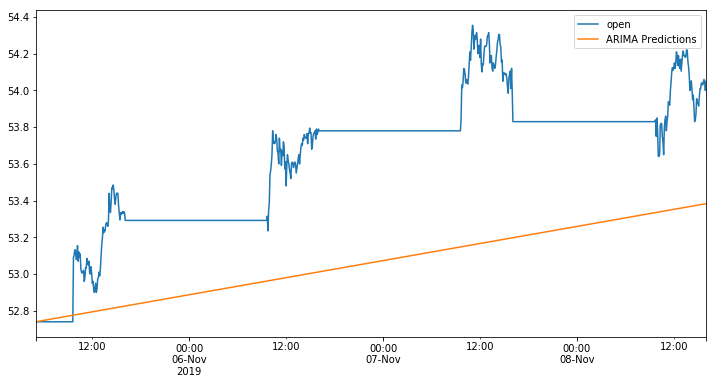

In [18]:
# Plot predictions against known values
title = ''
ylabel=''
xlabel='' # we don't really need a label here

ax = test['open'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
# ax.yaxis.set_major_formatter(formatter);

In [17]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['open'], predictions)
print(f'ARIMA(2,2,0) RMSE Error: {error:11.10}')

ARIMA(2,2,0) RMSE Error: 0.6025537931


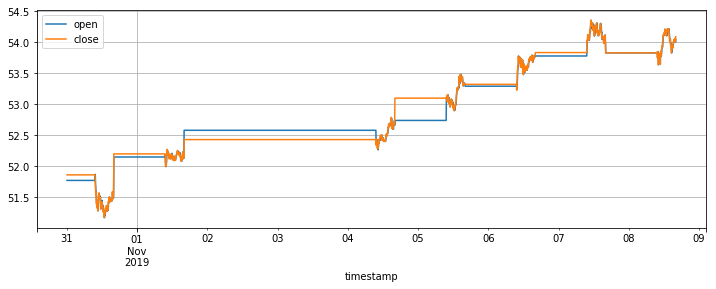

In [19]:
df[['open', 'close']].plot(figsize=(12,4), grid=True);

In [20]:
result = seasonal_decompose(df['open'], model='add')
result.plot();

ValueError: freq T not understood. Please report if you think this is in error.

In [ ]:
result.seasonal.plot(figsize=(16,4))

In [ ]:
auto_arima(df['open'], seasonal=True, m=10).summary()

In [ ]:
len(df)

In [ ]:
# Set one year for testing
train = df.iloc[:100]
test = df.iloc[100:]

In [ ]:
model = SARIMAX(train['open'],order=(0,1,0), seasonal_order=(1,0,1,10))
results = model.fit()
results.summary()

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

In [ ]:
predictions = predictions.reset_index(drop=True)
predictions.index = test.index

In [ ]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['open'][i]}")

In [ ]:
# Plot predictions against known values
title = ''
ylabel=''
xlabel=''

ax = test['open'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['open'], predictions)
print(f'ARIMA(2,2,0) RMSE Error: {error:11.10}')